# Fuzzy Logic Classification – 


## 1. Install libraries (sekali)

In [12]:
!pip install -q scikit-fuzzy scikit-learn pandas numpy matplotlib

## 2. Import

In [1]:
import pandas as pd, numpy as np, skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

## 3. Load dataset

In [7]:
df = pd.read_csv("obesity_data_processed_final1.csv")
print('Rows loaded:', len(df))
df.head()

Rows loaded: 998


,Age,Gender,Height,Weight,BMI,PhysicalActivityLevel,ObesityCategory
0,0.338886,1,0.340537,0.056720,-0.156007,1.311971,0
1,1.057069,1,-0.576678,1.226353,1.395983,-0.479202,1
2,-0.213562,0,-0.193705,0.118437,0.158517,1.311971,2
3,-0.986989,1,-0.156093,0.896336,0.827186,0.416385,2
4,0.559866,1,1.310694,-0.134764,-0.711890,0.416385,0


## 4. Build fuzzy system

In [8]:
X_cols = ['BMI', 'PhysicalActivityLevel', 'Age', 'Weight', 'Height', 'Gender']
y_col  = 'ObesityCategory'
df = df.dropna(subset=X_cols + [y_col]).reset_index(drop=True)


BMI_uni    = np.linspace(df['BMI'].min(),  df['BMI'].max(), 501)
Act_uni    = np.linspace(df['PhysicalActivityLevel'].min(), df['PhysicalActivityLevel'].max(), 501)
Age_uni    = np.linspace(df['Age'].min(),  df['Age'].max(), 501)
Weight_uni = np.linspace(df['Weight'].min(), df['Weight'].max(), 501)
Height_uni = np.linspace(df['Height'].min(), df['Height'].max(), 501)
Risk_uni   = np.linspace(0, 3, 301)
Gender_uni = np.array([0, 1])
 

Weight = ctrl.Antecedent(Weight_uni, 'Weight')
Height = ctrl.Antecedent(Height_uni, 'Height')
BMI      = ctrl.Antecedent(BMI_uni,'BMI')
Activity = ctrl.Antecedent(Act_uni,'Activity')
Age      = ctrl.Antecedent(Age_uni,'Age')
Gender  = ctrl.Antecedent(Gender_uni, 'Gender')
Risk     = ctrl.Consequent(Risk_uni,'Risk')


def add_mfs(var, q_vals, names):
    lo, hi = var.universe.min(), var.universe.max()
    a,b,c = sorted([float(x) for x in q_vals])
    var[names[0]] = fuzz.trimf(var.universe, [lo, a, b])
    var[names[1]] = fuzz.trimf(var.universe, [a, b, c])
    var[names[2]] = fuzz.trimf(var.universe, [b, c, hi])


Q = {c: df[c].quantile([.25, .5, .75]).values for c in [
    'BMI', 'PhysicalActivityLevel', 'Age', 'Weight', 'Height'
]}

add_mfs(BMI, Q['BMI'], ['low', 'medium', 'high'])
add_mfs(Activity, Q['PhysicalActivityLevel'], ['poor', 'fair', 'good'])
add_mfs(Age, Q['Age'], ['young', 'adult', 'senior'])
add_mfs(Weight, Q['Weight'], ['light', 'medium', 'heavy'])
add_mfs(Height, Q['Height'], ['short', 'average', 'tall'])


Gender['female'] = fuzz.trimf(Gender.universe, [0, 0, 1])
Gender['male']   = fuzz.trimf(Gender.universe, [0, 1, 1])


Risk['under'] = fuzz.trimf(Risk.universe,[0,0,1])
Risk['norm']  = fuzz.trimf(Risk.universe,[0,1,2])
Risk['over']  = fuzz.trimf(Risk.universe,[1,2,3])
Risk['obese'] = fuzz.trimf(Risk.universe,[2,3,3])


rule_grid = [
    (BMI['low'],    Activity['poor'],  'under'),
    (BMI['low'],    Activity['fair'],  'under'),
    (BMI['low'],    Activity['good'],  'under'),

    (BMI['medium'], Activity['poor'],  'over'),
    (BMI['medium'], Activity['fair'],  'over'),
    (BMI['medium'], Activity['good'],  'norm'),

    (BMI['high'],   Activity['poor'],  'obese'),
    (BMI['high'],   Activity['fair'],  'obese'),
    (BMI['high'],   Activity['good'],  'over'),
]

rules = [ctrl.Rule(cond1 & cond2, Risk[label]) for cond1,cond2,label in rule_grid]


rules += [
    ctrl.Rule(Age['senior'] & BMI['medium'] & Activity['fair'], Risk['over']),
    ctrl.Rule(Age['senior'] & BMI['high'],                        Risk['obese']),
]

rules += [
    ctrl.Rule(Gender['male'] & BMI['high'] & Activity['poor'], Risk['obese']),
    ctrl.Rule(Gender['female'] & BMI['medium'] & Activity['good'], Risk['norm']),
]

rules += [
    ctrl.Rule(Weight['heavy'] & Height['short'], Risk['obese']),
    ctrl.Rule(Weight['light'] & Height['tall'], Risk['under']),
    ctrl.Rule(Weight['medium'] & Height['average'], Risk['norm']),
]
system = ctrl.ControlSystem(rules)

## 5. Predict

In [9]:
y_pred = []
for row in df.itertuples(index=False):
    sim = ctrl.ControlSystemSimulation(system)
    sim.input['BMI']      = row.BMI
    sim.input['Activity'] = row.PhysicalActivityLevel
    sim.input['Age']      = row.Age
    sim.input['Gender']   = row.Gender  
    sim.input['Weight']   = row.Weight      
    sim.input['Height']   = row.Height     
    sim.compute()
    risk = sim.output.get('Risk', np.nan)
    if np.isnan(risk):  # fallback if somehow none
        risk = 1  # default to 'Normal'
    y_pred.append(int(np.clip(round(risk), 0, 3)))

print('Predictions done:', len(y_pred))


Predictions done: 998


### Metrics

              precision    recall  f1-score     support
0              0.440171  0.280654  0.342762  367.000000
1              0.019934  0.031746  0.024490  189.000000
2              0.628253  0.569024  0.597173  297.000000
3              0.015464  0.020690  0.017699  145.000000
accuracy       0.281563  0.281563  0.281563    0.281563
macro avg      0.275955  0.225528  0.245531  998.000000
weighted avg   0.354853  0.281563  0.310971  998.000000


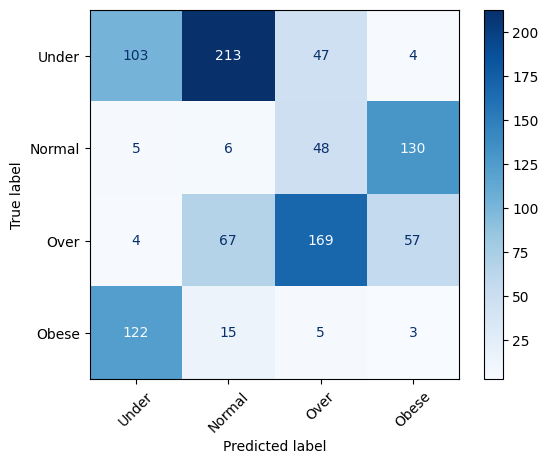

In [10]:
report = classification_report(df[y_col], y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)
cm = confusion_matrix(df[y_col], y_pred)
ConfusionMatrixDisplay(cm, display_labels=['Under','Normal','Over','Obese']).plot(cmap='Blues', xticks_rotation=45)
plt.show()

## 6. Save

In [11]:
df['Predicted'] = y_pred
df.to_csv('obesity_with_predictions_withgender.csv', index=False)
print('Saved to obesity_with_predictions_withgender.csv')

Saved to obesity_with_predictions_withgender.csv
